In [1]:
import pandas as pd
import random
import numpy as np
import time
import math
import sys
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import datatable as dt

from xgboost import plot_tree
from os import walk
from os import listdir
from os.path import isfile, join
from scipy.spatial.distance import euclidean, pdist, squareform
from scipy.stats import skew
from scipy.special import expit as sigmoid
from scipy.cluster.hierarchy import fclusterdata
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import precision_recall_fscore_support
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
DATA_PATH = ''
HISTORY_PATH = "Voter_History_{0}"
REGISTRATION_PATH = "data/{0}_VoterDetail"
COUNTY=sys.argv[1]

In [3]:
date_str = sys.argv[2]

In [4]:
from datetime import datetime
a = datetime.strptime("20190228", "%Y%m%d")

In [5]:
a.date()

datetime.date(2019, 2, 28)

In [6]:
a.date().day

28

In [7]:
COUPLES_SAVED_PATH= "couples_"+date_str+".csv"

In [13]:
largest_county = './'+COUNTY+'_'+date_str+'.txt'

In [11]:
registration_file_headers = [
    'county_code',
    'voter_id',
    'last_name',
    'suffix',
    'first_name',
    'middle_name',
    'requested_public_records_exemption',
    'residence_addr_line_1',
    'residence_addr_line_2',
    'residence_city',
    'residence_state',
    'residence_zipcode',
    'mail_addr_line_1',
    'mail_addr_line_2',
    'mail_addr_line_3',
    'mail_city',
    'mail_state',
    'mail_zipcode',
    'mail_country',
    'gender',
    'race',
    'birth_date',
    'registration_date',
    'party_affiliation',
    'precinct',
    'precinct_group',
    'precinct_split',
    'precinct_suffix',
    'voter_status',
    'congressional_district',
    'house_district',
    'senate_district',
    'county_commission_district',
    'school_board_district',
    'daytime_area_code',
    'daytime_phone_no',
    'daytime_phone_extension',
    'email_address'
]
selective_headers = [
    'first_name',
    'last_name',
    'birth_date',
    'county_code',
    'residence_addr_line_1',
    'residence_addr_line_2',
    'residence_city',
    'residence_zipcode',
    'gender',
    'race',
    'registration_date',
    'precinct',
    'voter_id',
    'party_affiliation',
    'voter_status'
]

In [12]:
global_df = pd.read_csv( REGISTRATION_PATH.format(date_str) + "/" + largest_county, sep='\t', names=registration_file_headers, usecols=selective_headers)

FileNotFoundError: [Errno 2] File b'data//home/rahullachh/.local/share/jupyter/runtime/kernel-bdfc91b4-8067-4261-87f5-280740a05aa1.json_VoterDetail/./-f_/home/rahullachh/.local/share/jupyter/runtime/kernel-bdfc91b4-8067-4261-87f5-280740a05aa1.json.txt' does not exist: b'data//home/rahullachh/.local/share/jupyter/runtime/kernel-bdfc91b4-8067-4261-87f5-280740a05aa1.json_VoterDetail/./-f_/home/rahullachh/.local/share/jupyter/runtime/kernel-bdfc91b4-8067-4261-87f5-280740a05aa1.json.txt'

In [ ]:
global_df.isnull().sum()

In [ ]:
req_cols = ['residence_city', 'gender', 'birth_date', 'precinct', 'first_name']
global_df = global_df.dropna(subset=req_cols)

In [ ]:
global_df.isnull().sum()

In [ ]:
global_df.shape

In [ ]:
from datetime import datetime
from datetime import date

def calculate_age(born):
    born = datetime.strptime(str(born), "%m/%d/%Y").date()
    today = datetime.strptime("08/13/2019", "%m/%d/%Y").date()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

global_df['age'] = global_df['birth_date'].apply(calculate_age)

In [ ]:
str_cols_lower = [
    'last_name',
    'first_name',
    'residence_addr_line_1',
    'residence_addr_line_2',
    'residence_city'
]
str_cols_upper = [
    'county_code',
    'gender',
    'party_affiliation',
    'voter_status'
]

In [ ]:
for col in str_cols_lower:
    global_df[col] = global_df[col].apply(lambda x: str(x).strip().lower())
for col in str_cols_upper:
    global_df[col] = global_df[col].apply(lambda x: str(x).strip().upper())

In [ ]:
global_df['residence_zipcode_5'] = global_df['residence_zipcode'].apply(lambda x: int(str(x)[:5]))

In [ ]:
def generate_zipcode_4(zip):
    zip = str(zip)
    if len(zip) > 5:
        return int(zip[-4:])
    else:
        return ''

global_df['residence_zipcode_4'] = global_df['residence_zipcode'].apply(generate_zipcode_4)

In [ ]:
global_df['uniq_addr'] = global_df[['residence_addr_line_1', 'residence_addr_line_2', 'residence_city', 'residence_zipcode_5']].apply(lambda x: ' '.join([str(y) for y in x]), axis=1)

In [ ]:
import re
global_df['uniq_addr'] = global_df['uniq_addr'].apply(lambda x: re.sub("[^0-9a-zA-Z\s]+", '', x))

In [ ]:
global_df['uniq_addr'] = global_df['uniq_addr'].apply(lambda x: x.strip())

In [ ]:
aggregated_df = global_df.groupby(['uniq_addr', 'last_name'])['last_name'].agg(['count']).reset_index()

In [ ]:
global_df_copy = global_df.copy(deep=True)

In [ ]:
merge = pd.merge(global_df, global_df_copy, on=["uniq_addr"], suffixes=["_L", "_R"])

In [ ]:
merge = merge[merge["voter_id_L"] != merge["voter_id_R"]]

In [ ]:
merge.shape

In [ ]:
filtered = merge[merge["voter_id_L"] < merge["voter_id_R"]]

In [ ]:
filtered.shape

In [ ]:
def modified_couple_heuristic(row):
    male_age_threshold = 27
    female_age_threshold = 25
    unknown_age_threshold = 26
    age_diff_threshold = 15
    
    age_diff = abs(row['age_L'] - row['age_R'])
    
    is_age_threshold_L = False
    if row["gender_L"] == "M" and row["age_L"] >= male_age_threshold: 
        is_age_threshold_L = True
    elif row["gender_L"] == "F" and row["age_L"] >= female_age_threshold:
        is_age_threshold_L = True
    elif row["gender_L"] == "U" and row["age_L"] >= unknown_age_threshold:
        is_age_threshold_L = True

    
        
    is_age_threshold_R = False
    if row["gender_R"] == "M" and row["age_R"] >= male_age_threshold: 
        is_age_threshold_R = True
    elif row["gender_R"] == "F" and row["age_R"] >= female_age_threshold:
        is_age_threshold_R = True
    elif row["gender_R"] == "U" and row["age_R"] >= unknown_age_threshold:
        is_age_threshold_R = True
    
    return is_age_threshold_L and is_age_threshold_R and age_diff <= age_diff_threshold
        

In [ ]:
couples = filtered[filtered.apply(modified_couple_heuristic, axis=1)]

In [ ]:
from multiprocessing import  Pool
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
#couples = parallelize_dataframe(filtered, modified_couple_heuristic, 8)

In [ ]:
couples.shape

#### https://datascience.stackexchange.com/questions/26308/after-grouping-to-minimum-value-in-pandas-how-to-display-the-matching-row-resul
#### https://jamesrledoux.com/code/drop_duplicates

In [ ]:
couples["age_diff"] = couples.apply(lambda row: abs(row["age_L"] - row["age_R"]), axis=1)

In [ ]:
sorted_couples = couples.sort_values(by="age_diff")

In [ ]:
single_house_couples = sorted_couples.drop_duplicates(subset="uniq_addr", keep="first")

In [ ]:
def appendDFToCSV_void(df, csvFilePath, sep="\t"):
    import os
    if not os.path.isfile(csvFilePath):
        df.to_csv(csvFilePath, mode='a', index=False, sep=sep)
    elif len(df.columns) != len(pd.read_csv(csvFilePath, nrows=1, sep=sep).columns):
        raise Exception("Columns do not match!! Dataframe has " + str(len(df.columns)) + " columns. CSV file has " + str(len(pd.read_csv(csvFilePath, nrows=1, sep=sep).columns)) + " columns.")
    elif not (df.columns == pd.read_csv(csvFilePath, nrows=1, sep=sep).columns).all():
        raise Exception("Columns and column order of dataframe and csv file do not match!!")
    else:
        df.to_csv(csvFilePath, mode='a', index=False, sep=sep, header=False)

In [ ]:
single_house_couples.to_csv(COUPLES_SAVED_PATH, sep="\t")

In [2]:
global_df = pd.read_csv("preprocessed/20190910/florida_processed_20190910.csv", sep='\t')

/home/rahullachh/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
agg = global_df.groupby(["county_code"])["age"].agg(["mean"]).reset_index()

In [11]:
agg = agg.rename(columns={"mean": "mean age"})

In [15]:
agg.sort_values(by=["mean age"])

,county_code,mean age
36,LEO,43.660619
0,ALA,44.576229
47,ORA,45.780784
48,OSC,47.255149
28,HIL,47.387227
...,...,...
27,HIG,57.433601
8,CIT,57.845684
55,SAR,57.968298
7,CHA,59.254200


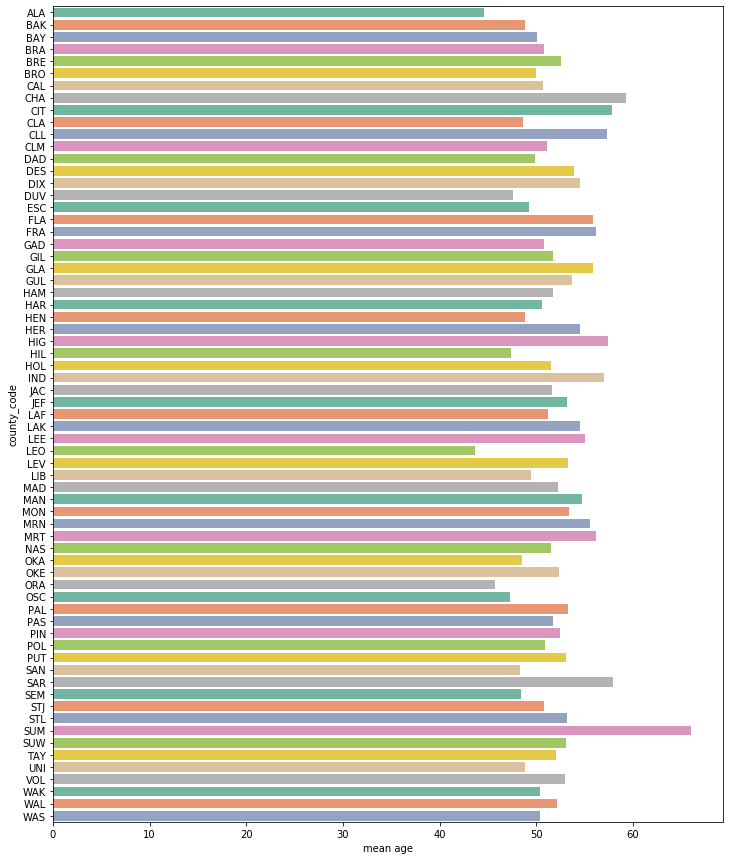

In [13]:
figures, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,15))
sns.barplot(x="mean age", y="county_code", data=agg, palette=sns.color_palette("Set2"), ax=axes)
plt.savefig("countywise_mean_age")